# Assignment
In this assignment, you'll be working with the heart disease dataset from the UC Irvine Machine Learning Repository.

- Load the dataset from the Thinkful's database. Here's the credentials you can use to connect to the database:
        postgres_user = 'dsbc_student'
        postgres_pw = '7*.8G9QH21'
        postgres_host = '142.93.121.174'
        postgres_port = '5432'
        postgres_db = 'heartdisease'
- The dataset needs some preprocessing. So, apply the following code before working with the dataset:
        # Define the features and the outcome
        X = heartdisease_df.iloc[:, :13]
        y = heartdisease_df.iloc[:, 13]

        # Replace missing values (marked by ?) with a 0
        X = X.replace(to_replace='?', value=0)

        # Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
        y = np.where(y > 0, 0, 1)
        
Here, X will be your features and in y we hold the labels. If y is equal to 1, then it indicates that the corresponding patient has heart disease and if y is equal to 0, then the patient doesn't have heart disease.

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks below, and plan on discussing with your mentor. You can also take a look at these example solutions.

1. Apply DBSCAN to the heart disease data by trying different values for eps and min_samples parameters. You'll realize that it's really hard to get a two cluster solution using DBSCAN if not impossible.
2. Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of min_samples. What's the effect of increasing min_samples on the number of clusters DBSCAN identifies?
3. Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of eps. What's the effect of increasing eps on the number of clusters DBSCAN identifies?

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sqlalchemy import create_engine

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heart_disease = engine.execute('SELECT * FROM heartdisease').fetchall()
engine.dispose()

In [9]:
heartdisease_df = pd.DataFrame(heart_disease)
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]
X = X.replace(to_replace='?', value=0)
y = np.where(y > 0, 0, 1)

In [10]:
scaler = StandardScaler()

In [12]:
X_std = scaler.fit_transform(X)

# #1

In [41]:
len(pd.Series(DBSCAN().fit_predict(X_std)).unique())

1

In [30]:
eps_params = np.arange(.1, 10.1, .1)
min_params = range(1, 11, 1)

In [65]:
possible_combos = []
for eps in eps_params:
    for min_p in min_params:
        preds = DBSCAN(eps=eps, min_samples=min_p).fit_predict(X_std)
        accuracy = (preds == y).mean()
        no_groups = len(pd.Series(preds).unique())
        uniques = [x for x in pd.Series(preds).unique()]
        if (no_groups == 3 and 2 not in uniques) or (no_groups == 2 and -1 not in uniques):           
            possible_combos.append((eps, min_p, metrics.adjusted_rand_score(y, preds)))

In [75]:
max([x[2] for x in possible_combos])

0.16537486397151183

In [77]:
for x in possible_combos:
    if x[2] > .15:
        print(x[0], x[1], x[2])

2.5000000000000004 8 0.1518539374364039
2.6 10 0.16537486397151183


In [78]:
best_preds = DBSCAN(eps=2.6, min_samples=10).fit_predict(X_std)

In [81]:
pd.crosstab(y, best_preds)

col_0,-1,0,1
row_0,,,
0,81,43,15
1,60,9,95


Best I think I can do with this, it thinks there is a lot of noise, but when it isn't detected as noise, it categorizes pretty well.

# #2 
Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of min_samples. What's the effect of increasing min_samples on the number of clusters DBSCAN identifies?

In [102]:
x_y = []
for i in range(1, 31):
    preds = DBSCAN(eps=1, min_samples=i, metric='euclidean').fit_predict(X_std)
    clusters = len(pd.Series(preds).unique())
    x_y.append((i, clusters))

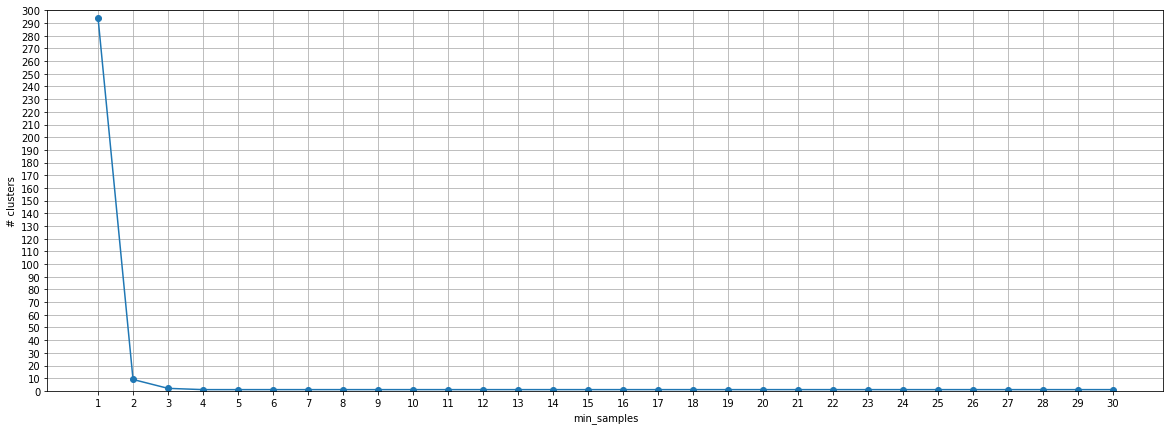

In [108]:
plt.figure(figsize=(20, 7))
plt.plot([x[0] for x in x_y], [y[1] for y in x_y], marker='o')
plt.xlabel('min_samples')
plt.xticks(ticks=range(1,31),labels=range(1,31))
plt.ylim(0, 300)
plt.yticks(ticks=range(0,310,10), labels=range(0,310, 10))
plt.ylabel('# clusters')
plt.grid()
plt.show()

# #3
Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of eps. What's the effect of increasing eps on the number of clusters DBSCAN identifies?

In [110]:
x_y = []
for i in range(1, 31):
    preds = DBSCAN(eps=i, min_samples=1, metric='euclidean').fit_predict(X_std)
    clusters = len(pd.Series(preds).unique())
    x_y.append((i, clusters))

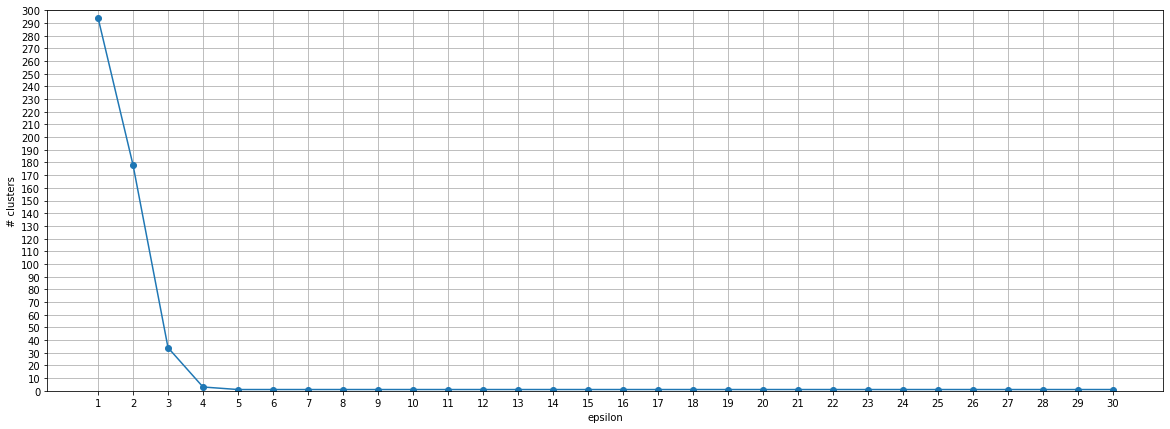

In [111]:
plt.figure(figsize=(20, 7))
plt.plot([x[0] for x in x_y], [y[1] for y in x_y], marker='o')
plt.xlabel('epsilon')
plt.xticks(ticks=range(1,31),labels=range(1,31))
plt.ylim(0, 300)
plt.yticks(ticks=range(0,310,10), labels=range(0,310, 10))
plt.ylabel('# clusters')
plt.grid()
plt.show()

# Extra

In [115]:
possible_combos = []
for eps in eps_params:
    for min_p in min_params:
        preds = DBSCAN(eps=eps, min_samples=min_p).fit_predict(X_std)
        accuracy = (preds == y).mean()
        no_groups = len(pd.Series(preds).unique())
        uniques = [x for x in pd.Series(preds).unique()]
        if (no_groups == 2 and -1 not in uniques):           
            possible_combos.append((preds, eps, min_p, metrics.adjusted_rand_score(y, preds)))

In [117]:
for pred, eps, min_p, ari in possible_combos:
    print(pd.crosstab(y, pred))

col_0    0  1
row_0        
0      139  0
1      163  1
col_0    0  1
row_0        
0      139  0
1      163  1
col_0    0  1
row_0        
0      139  0
1      163  1


No great sol'n here, best was probably what was found in question 1.